<a href="https://colab.research.google.com/github/ferngonzalezp/Langevin-GAN/blob/master/lstm_gan_langevin_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [448]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


#Generation of Data

In [449]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
# Batch size during training
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
nz = 150

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.0

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

ncritic = 5

## Main parameter:


*   nPred : 1/4 number of succesive points to  predict (should be multiple of 4 due to successive convolution later on)
*    nPer: number of correlation time to consider
*    nRand: number of random number used to generate the signal

   

In [0]:
nPred=50 #x4 !
nPer= 4 
nRand=20
Tl = (0.05, 0.1, 1)

In [0]:
#Modules utilisés

import numpy as np
import matplotlib.pyplot as plt


#Resolution de l'équation de Langevin

def generateLangevin(LagrangeTime,nPerd,nPts,var,uIni=0.):
  v0=uIni
  vari=var
  TL=LagrangeTime
  t_depart=0.
  t_final=nPerd*TL
  N=nPts
  dt=(t_final-t_depart)/N
  t=np.linspace(t_depart,t_final,N)

  Csta=1./TL
  Cstb=Csta*2*vari

  val_u=[v0] #liste qui va contenir les valeurs de vitesse
    
  for i in range(1,N):
    val_u.append(val_u[i-1]-Csta*val_u[i-1]*dt+np.sqrt(Cstb*dt)*np.random.normal(0,1)) 
  return val_u

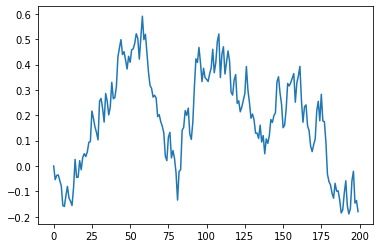

In [453]:
u=generateLangevin(.05,nPer,nPred*4,0.1)
plt.plot(u)

In [454]:
BUFFER_SIZE = 5000
BATCH_SIZE = batch_size

train_sigs=[]
labels = []
for j in range(len(Tl)) :
  for i in range(BUFFER_SIZE) :
    train_sigs.append(generateLangevin(Tl[j],nPer,nPred*4,0.1))
    labels.append(Tl[j])
train_sigs=np.array(train_sigs)
labels = np.array(labels)
print(train_sigs.shape)

train_sigs = train_sigs.reshape(train_sigs.shape[0],nPred*4,1).astype('float32')
print(train_sigs.shape)
print(labels.shape)


(15000, 200)
(15000, 200, 1)
(15000,)


In [0]:
#Create Dataset
train_sigs = torch.tensor(train_sigs)
labels = torch.reshape(torch.tensor(labels, dtype=torch.float),(labels.shape[0],1))
dataset = torch.utils.data.TensorDataset(train_sigs,labels)
#Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)

In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

#Generator

In [0]:
class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.hidden_dim = 128
        self.lstm_cell = nn.LSTMCell(self.hidden_dim,self.hidden_dim)
        self.fc1 = nn.Sequential(
            nn.Linear(nz+1,self.hidden_dim),
            nn.ReLU(True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.hidden_dim,1,bias=False),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1,1,bias=False),
            nn.ReLU(True)
        )
        def init_hidden(self, batch_size):
          ''' Initialize hidden state '''
          # create NEW tensor with SAME TYPE as weight
          weight = next(self.parameters()).data

          if (self.ngpu >= 1):
              
              hidden = ((weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08).cuda(),
                        weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08).cuda()),
                        (weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08).cuda(),
                        weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08).cuda()))
              """
              hidden = ((weight.new(batch_size, self.hidden_dim).zero_.cuda(),
                        weight.new(batch_size, self.hidden_dim).zero_.cuda()),
                        (weight.new(batch_size, self.hidden_dim).zero_.cuda(),
                        weight.new(batch_size, self.hidden_dim).zero_.cuda()))
              """
          else:
              hidden = ((weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08),
                        weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08)),
                        (weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08),
                        weight.new(batch_size, self.hidden_dim).normal_(mean=0,std=0.08)))
              """
            hidden = ((weight.new(batch_size, self.hidden_dim).zero_.cuda(),
                        weight.new(batch_size, self.hidden_dim).zero_.cuda()),
                        (weight.new(batch_size, self.hidden_dim).zero_.cuda(),
                        weight.new(batch_size, self.hidden_dim).zero_.cuda()))
              """
          return hidden
    def forward(self, z, Tl, n_points):
        l_size = Tl.size()
        Tl = torch.reshape(self.fc3(Tl),(l_size[0],1))
        h_0 = torch.randn(l_size[0],self.hidden_dim).to(device)
        c_0 = torch.randn(l_size[0],self.hidden_dim).to(device)
        seq = torch.empty(l_size[0],1).to(device)
        y_0 = Tl
        for i in range(n_points):
          noise = torch.cat((z[:,:,i],y_0),dim=1)
          y_0 = self.fc1(noise)
          h_0, c_0 = self.lstm_cell(y_0,(h_0,c_0))
          y_0 = self.fc2(h_0)
          seq = torch.cat((seq,y_0),dim=1)
        return torch.reshape(seq[:,1:],(l_size[0],n_points,1))

In [459]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (lstm_cell): LSTMCell(128, 128)
  (fc1): Sequential(
    (0): Linear(in_features=151, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): ReLU(inplace=True)
  )
)


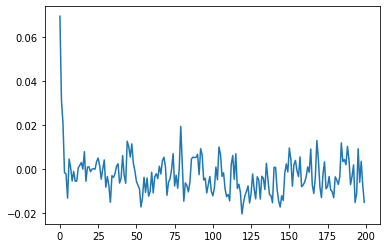

In [460]:
z = torch.randn(128,nz,nPred*4,device=device)
label = torch.ones(128,1,device=device)*0.05
gen_sig = netG(z,label,nPred*4)
plt.plot(gen_sig[0,:,0].cpu().detach().numpy())

In [461]:
z[:,:,0].shape

torch.Size([128, 150])

#Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.fc = nn.Sequential(
            nn.Linear(1,1,bias=False),
            nn.LeakyReLU(True)
        )
        self.mlp = nn.Sequential(
            nn.Linear(nPred*4+1,128),
            nn.LeakyReLU(0.2,True),
            nn.Linear(128,128),
            nn.LeakyReLU(0.2,True),
            nn.Linear(128,128),
            nn.LeakyReLU(0.2,True),
            nn.Linear(128,64),
            nn.LeakyReLU(0.2,True),
            nn.Linear(64,1)
        )
        
    def forward(self, signal, Tl):
        l_size = signal.size()
        Tl = torch.reshape(Tl,(l_size[0],1))
        Tl = torch.reshape(self.fc(Tl),(l_size[0],1,1))
        signal = torch.cat((signal,Tl),dim=1)
        signal = torch.reshape(signal,(l_size[0],1,signal.shape[1]))
        validity = self.mlp(signal).mean(dim=1)
        validity = validity.reshape((l_size[0],1))
        return validity

In [0]:
class Discriminator2(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator2, self).__init__()
        self.ngpu = ngpu
        self.fc = nn.Sequential(
            nn.Linear(1,1,bias=False),
            nn.LeakyReLU(True)
        )
        self.main = nn.Sequential(
            # input is nz x 1 x 1
            (nn.Conv2d(nPred*4+1, 64 * 4, (5,1), (2,1), (2,0), bias=False)),
            nn.LeakyReLU(0.2,inplace=True),
            # state size. (ndf*2) x 1 x 1
            (nn.Conv2d(64 * 4, 64 * 2, (5,1), (2,1), (2,0), bias=False)),
            nn.LeakyReLU(0.2,inplace=True),
            # state size. (ndf*4) x 1 x 1
            (nn.Conv2d(64 * 2, 64, (5,1), (2,1), (2,0), bias=False)),
            nn.LeakyReLU(0.2,inplace=True),
            (nn.Conv2d(64, 1, (5,1), (2,1), (2,0), bias=False)),
 
        )

    def forward(self, noise,label):
        l_size = label.size()
        label = torch.reshape(label,(l_size[0],1))
        label = torch.reshape(self.fc(label),(l_size[0],1,1,1))
        noise = torch.reshape(noise,(l_size[0],nPred*4,1,1))
        noise = torch.cat((noise,label),dim=1)
        return self.main(noise)

In [464]:
# Create the Discriminator
netD = Discriminator2(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator2(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): LeakyReLU(negative_slope=True)
  )
  (main): Sequential(
    (0): Conv2d(201, 256, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 128, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 64, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 1, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
  )
)


In [465]:
prob = netD(train_sigs.to(device),labels.to(device))
print(prob.mean())
print(prob)

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[[[-7.5155e-05]]],


        [[[-3.0046e-05]]],


        [[[ 1.5825e-04]]],


        ...,


        [[[-1.3983e-04]]],


        [[[ 2.9225e-04]]],


        [[[-4.8480e-05]]]], device='cuda:0',
       grad_fn=<CudnnConvolutionBackward>)


#GAN

In [0]:
# Initialize loss function
def criterion(y):
  return torch.mean(y)
# Setup Adam optimizers for both G and D
optimizerD =  optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.9))

In [0]:
def stat_constraint(x,y):
  meanx = torch.mean(x,dim=0)
  meany = torch.mean(y,dim=0)
  return torch.autograd.Variable((torch.mean(meanx-meany)**2),requires_grad=True)

In [0]:
def stat_constraint2(x):
  mean = torch.mean(torch.mean(x,dim=1),dim=0)
  std = torch.mean(torch.std(x,dim=1), dim = 0)
  skewness = torch.mean(torch.mean(torch.div((x-mean),std)**3,dim=1),dim=0)
  skewness = torch.autograd.Variable(skewness,requires_grad=True)
  return skewness**2

In [0]:
def auto_cor(v):
  result = np.correlate(v,v,mode='full')
  return result/result.max()

In [0]:
def stat_constraint3(x,y):
  b_size = x.shape[0]
  s1 = np.array(0)
  s2 = np.array(0)
  for i in range(b_size):
    s1 = s1 + auto_cor(x[i,:,0].cpu().detach().numpy())
    s2 = s2 + auto_cor(y[i,:,0].cpu().detach().numpy())
  s1 = torch.tensor(s1, requires_grad=True).to(device)/b_size
  s2 = torch.tensor(s2, requires_grad=True).to(device)/b_size
  return (torch.mean(((s1-s2)**2)))**0.5

In [0]:
def score(x,y):
  b_size = x.shape[0]
  x = torch.reshape(x,(b_size,x.shape[1],1))
  xt = torch.transpose(x,1,2)
  y = torch.reshape(y,(b_size,y.shape[1],1))
  yt = torch.transpose(y,1,2)
  covx = torch.mean(torch.matmul(x,xt),dim=0)-torch.matmul(torch.mean(x,dim=0),torch.mean(xt,dim=0))
  covy = torch.mean(torch.matmul(y,yt),dim=0)-torch.matmul(torch.mean(y,dim=0),torch.mean(yt,dim=0))
  term1 = torch.mean(((torch.mean(x,dim=1)-torch.mean(y,dim=1))**2)**0.5,dim=0)
  term2 = torch.trace(covx+covy-2*(covx*covy)**0.5)
  return term1 + term2

In [0]:
#Valid an fake labels
real_label = 1
fake_label = 0

In [0]:
def calc_gradient_penalty(netD, real_data, generated_data,y):
    # GP strength
    LAMBDA = 10

    b_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size, nPred*4, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.cuda()

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)
    interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated,y)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return LAMBDA * ((gradients_norm - 1) ** 2).mean()

In [474]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
Score = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, classes) in enumerate(dataloader,0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        class_real = classes.to(device)
        b_size = real_cpu.size()
        # Forward pass real batch through D
        output = netD(real_cpu,class_real)
        # Calculate loss on all-real batch
        errD_real = criterion(output)
        D_x = errD_real.item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size[0], nz, nPred*4, device=device)
        class_fake = class_real[torch.randperm(b_size[0])]
        # Generate fake image batch with G
        fake = netG(noise,class_fake,nPred*4)
        # Classify all fake batch with D
        output = netD(fake,class_real)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output)
        D_G_z1 = errD_fake.item()
        #calculate gradient penalty
        grad_penalty = calc_gradient_penalty(netD,real_cpu,fake,class_real)
        #grad_penalty = calc_gradient_penalty(netD,real_cpu,fake,class_real)
        # Add the gradients and penalty from the all-real and all-fake batches
        errD = -errD_real + errD_fake + grad_penalty
        errD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if iters % ncritic == 0:
          netG.zero_grad()
          # Since we just updated D, perform another forward pass of all-fake batch through D
          noise = torch.randn(b_size[0], nz, nPred*4, device=device)
          class_fake = class_real[torch.randperm(b_size[0])]
          fake = netG(noise,class_fake,nPred*4)
          output = netD(fake,class_real)
          # Calculate G's loss based on this output
          errG = -criterion(output) + 100*stat_constraint(fake,real_cpu) + 100*stat_constraint2(fake) + 100*stat_constraint3(real_cpu,fake)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = errG.item()
          # Update G
          optimizerG.step()

          FID = score(real_cpu,fake)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f \t FID: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,FID))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        Score.append(FID.item())
        iters += 1

Starting Training Loop...
[0/150][0/118]	Loss_D: 9.9780	Loss_G: 26.7605	D(x): 0.0001	D(G(z)): 0.0000 / 26.7605 	 FID: 15.9143
[0/150][50/118]	Loss_D: 8.3628	Loss_G: 1218.2332	D(x): 0.0039	D(G(z)): 0.0034 / 1218.2332 	 FID: 17.0223
[0/150][100/118]	Loss_D: 2.3358	Loss_G: 2476.6882	D(x): 0.0159	D(G(z)): 0.0390 / 2476.6882 	 FID: 15.0900
[1/150][0/118]	Loss_D: 0.6157	Loss_G: 1912.9673	D(x): 0.0302	D(G(z)): 0.0487 / 1912.9673 	 FID: 15.8801
[1/150][50/118]	Loss_D: -0.1357	Loss_G: 1521.5239	D(x): -0.0223	D(G(z)): -0.2538 / 1521.5239 	 FID: 17.7336
[1/150][100/118]	Loss_D: -0.2041	Loss_G: 866.5645	D(x): 0.2383	D(G(z)): -0.1584 / 866.5645 	 FID: 17.4737
[2/150][0/118]	Loss_D: -0.2164	Loss_G: 135.9323	D(x): 0.4023	D(G(z)): -0.0732 / 135.9323 	 FID: 15.2901
[2/150][50/118]	Loss_D: 0.6314	Loss_G: 217.8258	D(x): 0.4112	D(G(z)): 0.1889 / 217.8258 	 FID: 19.3710
[2/150][100/118]	Loss_D: 1.0298	Loss_G: 1494.0205	D(x): 0.5708	D(G(z)): 0.5862 / 1494.0205 	 FID: 17.3863
[3/150][0/118]	Loss_D: 1.1421	Lo

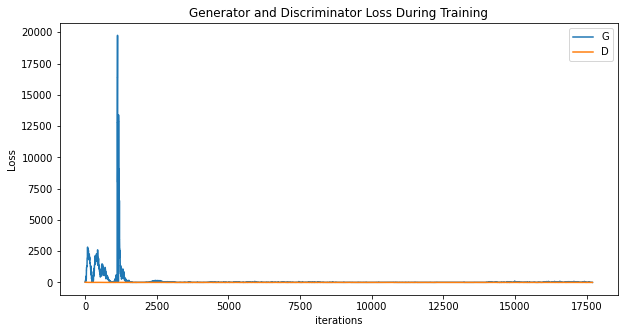

In [475]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

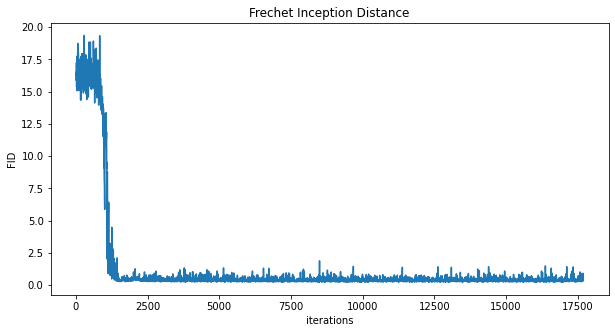

In [476]:
plt.figure(figsize=(10,5))
plt.title("Frechet Inception Distance")
plt.plot(Score)
plt.xlabel("iterations")
plt.ylabel("FID")
plt.show()

#Results

In [0]:
#netG.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/lstm_gan.pt'))

In [0]:
num_examples_to_generate = 5000
#Generate Langevin with Tl = 0.05
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate,nz,nPred*4, device=device)
label = torch.tensor(np.ones((num_examples_to_generate,1))*Tl[0],dtype=torch.float)
label = label.to(device)
predicted_langevin_1 = netG(noise,label,nPred*4)
predicted_langevin_1 = predicted_langevin_1.cpu().detach().numpy()
#Generate Langevin with Tl = 0.1
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate,nz,nPred*4, device=device)
label = torch.tensor(np.ones((num_examples_to_generate,1))*Tl[1],dtype=torch.float)
label = label.to(device)
predicted_langevin_2 = netG(noise,label,nPred*4)
predicted_langevin_2 = predicted_langevin_2.cpu().detach().numpy()
#Generate Langevin with Tl = 1
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate,nz,nPred*4, device=device)
label = torch.tensor(np.ones((num_examples_to_generate,1))*Tl[2],dtype=torch.float)
label = label.to(device)
predicted_langevin_3 = netG(noise,label,nPred*4)
predicted_langevin_3 = predicted_langevin_3.cpu().detach().numpy()


In [0]:
t = np.linspace(0,4,nPred*4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  del sys.path[0]


Text(0.5, 0, 't/Tl')

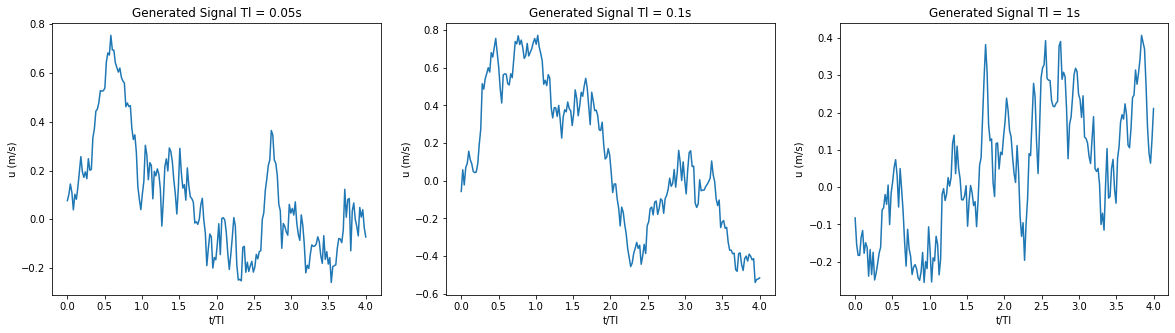

In [480]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(t,predicted_langevin_1[np.random.random_integers(0,4999),:,0])
plt.title("Generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
plt.subplot(1,3,2)
plt.plot(t,predicted_langevin_2[np.random.random_integers(0,4999),:,0])
plt.title("Generated Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
plt.subplot(1,3,3)
plt.plot(t,predicted_langevin_3[np.random.random_integers(0,4999),:,0])
plt.title("Generated Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")

Text(0.5, 0, 't/Tl')

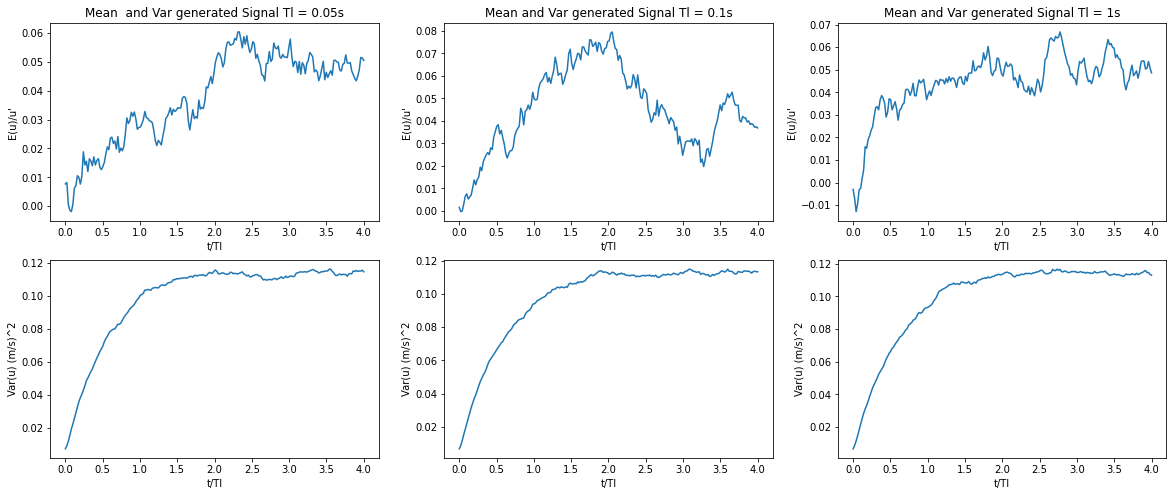

In [481]:
plt.figure(figsize=(20,8))
mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_1[i,:,0]
    var_gen = var_gen + predicted_langevin_1[i,:,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen1 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)

plt.subplot(2,3,1)
plt.plot(t,mean_gen)
plt.title("Mean  and Var generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,4)
plt.plot(t,var_gen1)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_2[i,:,0]
    var_gen = var_gen + predicted_langevin_2[i,:,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen2 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,3,2)
plt.plot(t,mean_gen)
plt.title("Mean and Var generated Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,5)
plt.plot(t,var_gen2)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_3[i,:,0]
    var_gen = var_gen + predicted_langevin_3[i,:,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen3 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,3,3)
plt.plot(t,mean_gen)
plt.title("Mean and Var generated Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,6)
plt.plot(t,var_gen3)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

In [482]:
var_mean = np.var(mean_gen)
print(var_mean)

0.00018014134323198595


In [483]:
print(max(var_gen1))
print(np.mean(var_gen1[50:]))

0.11617838158212286
0.1116900021484687


Text(0.5, 0, 'tau (s)')

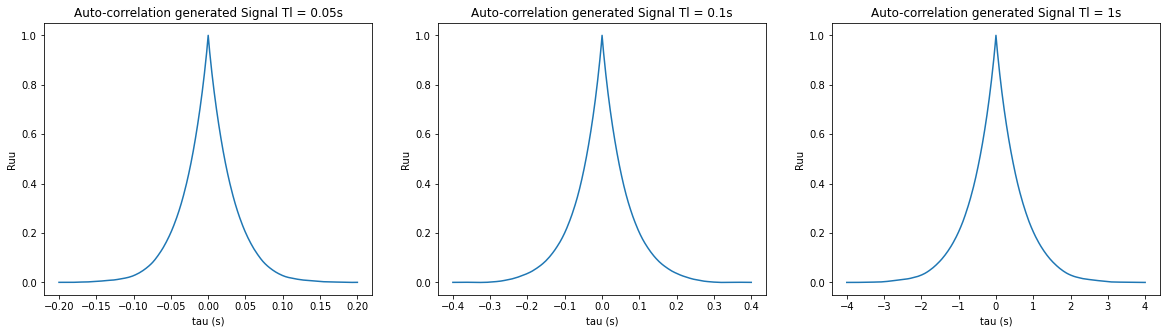

In [484]:
plt.figure(figsize=(20,5))
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_1[i,:,0])
Ruu_1 = Ruu/num_examples_to_generate
plt.subplot(1,3,1)
plt.plot(np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1),Ruu_1)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_2[i,:,0])
Ruu_2 = Ruu/num_examples_to_generate
plt.subplot(1,3,2)
plt.plot(np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1),Ruu_2)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_3[i,:,0])
Ruu_3 = Ruu/num_examples_to_generate
plt.subplot(1,3,3)
plt.plot(np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1),Ruu_3)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")

In [485]:
Tl_emp1 = np.trapz(Ruu_1,np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1))
Tl_emp2 = np.trapz(Ruu_2,np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1))
Tl_emp3 = np.trapz(Ruu_3,np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1))
print(Tl_emp1,Tl_emp2,Tl_emp3)


0.060532441341945464 0.12149691905817886 1.2219102902915744


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning:

Text(0.5, 1.0, 'PDF generated Signal Tl = 1s')

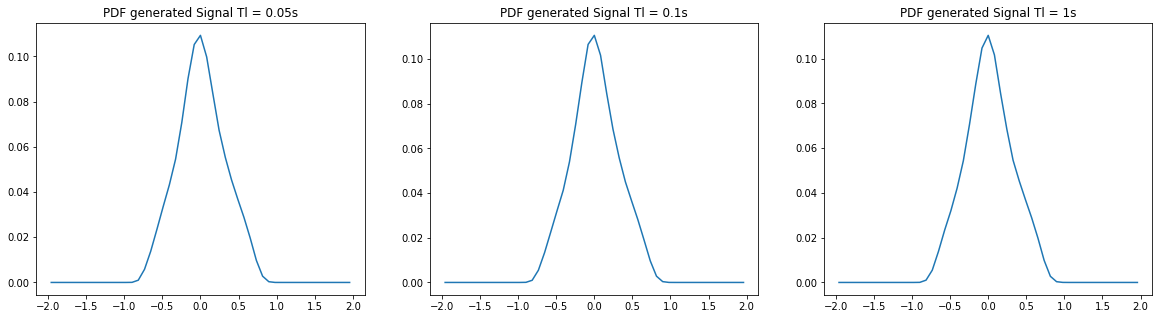

In [486]:
plt.figure(figsize=(20,5))
bins = np.linspace(-2,2,50)
hist_1,_ = np.histogram(predicted_langevin_1,bins = bins,normed=True)
hist_1 = hist_1/np.sum(hist_1)
plt.subplot(1,3,1)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_1)
plt.title("PDF generated Signal Tl = "+ str(Tl[0])+"s")
hist_2,_ = np.histogram(predicted_langevin_2,bins = bins,normed=True)
hist_2 = hist_2/np.sum(hist_2)
plt.subplot(1,3,2)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_2)
plt.title("PDF generated Signal Tl = "+ str(Tl[1])+"s")
hist_3,_ = np.histogram(predicted_langevin_3,bins = bins,normed=True)
hist_3 = hist_3/np.sum(hist_3)
plt.subplot(1,3,3)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_3)
plt.title("PDF generated Signal Tl = "+ str(Tl[2])+"s")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  app.launch_new_instance()


Text(0.5, 0, 't/Tl')

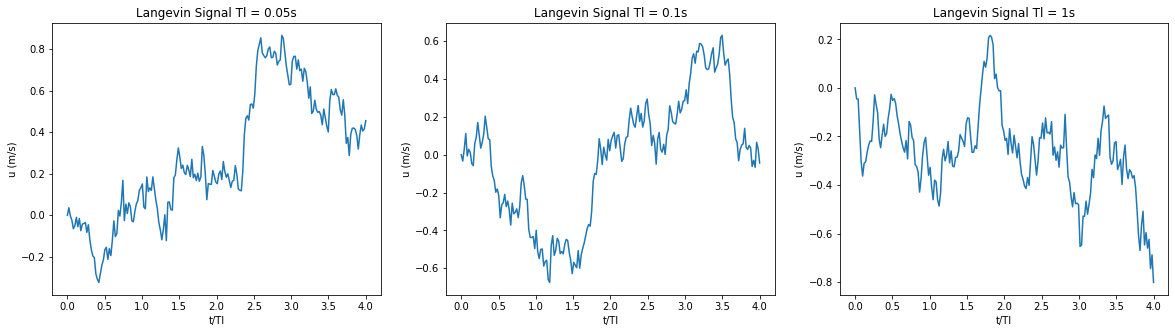

In [487]:
plt.figure(figsize=(20,5))
langevin_1 = train_sigs[0:5000].cpu().detach().numpy()
plt.subplot(1,3,1)
plt.plot(t,langevin_1[np.random.random_integers(0,4999),:,0])
plt.title("Langevin Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
langevin_2 = train_sigs[5000:10000].cpu().detach().numpy()
plt.subplot(1,3,2)
plt.plot(t,langevin_2[np.random.random_integers(0,4999),:,0])
plt.title("Langevin Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
langevin_3 = train_sigs[10000:15000].cpu().detach().numpy()
plt.subplot(1,3,3)
plt.plot(t,langevin_3[np.random.random_integers(0,4999),:,0])
plt.title("Langevin Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")

Text(0.5, 0, 't/Tl')

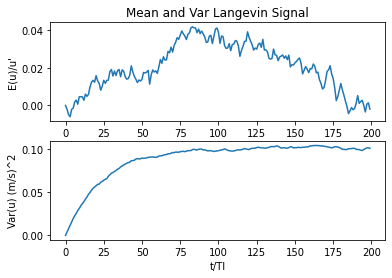

In [488]:
mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ langevin_1[i,:,0]
    var_gen = var_gen + langevin_1[i,:,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,1,1)
plt.plot(mean_gen)
plt.title("Mean and Var Langevin Signal")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,1,2)
plt.plot(var_gen)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

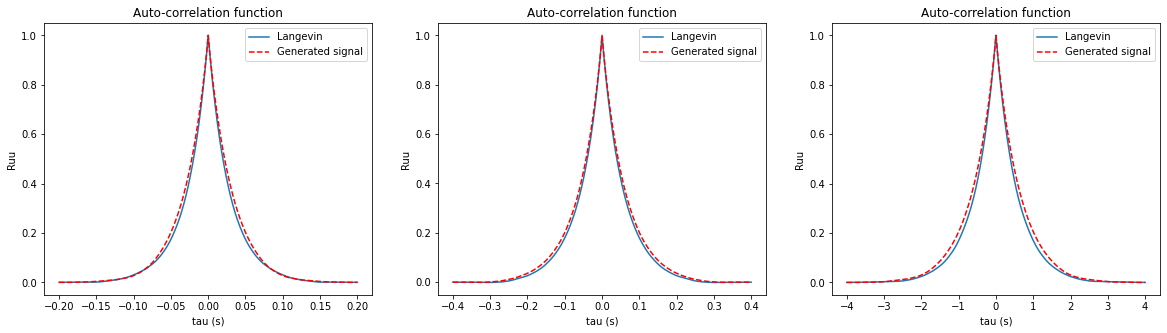

In [489]:
plt.figure(figsize=(20,5))
Ruu_real = np.array(0);
for i in range(num_examples_to_generate):
  Ruu_real = Ruu_real + auto_cor(langevin_1[i,:,0])
Ruu_real = Ruu_real/num_examples_to_generate
plt.subplot(1,3,1)
plt.title('Auto-correlation function')
plt.plot(np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1),Ruu_real,label='Langevin')
plt.plot(np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1),Ruu_1,'r--',label='Generated signal')
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
plt.legend()

Ruu_real = np.array(0);
for i in range(num_examples_to_generate):
  Ruu_real = Ruu_real + auto_cor(langevin_2[i,:,0])
Ruu_real = Ruu_real/num_examples_to_generate
plt.subplot(1,3,2)
plt.title('Auto-correlation function')
plt.plot(np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1),Ruu_real,label='Langevin')
plt.plot(np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1),Ruu_2,'r--',label='Generated signal')
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
plt.legend()

Ruu_real = np.array(0);
for i in range(num_examples_to_generate):
  Ruu_real = Ruu_real + auto_cor(langevin_3[i,:,0])
Ruu_real = Ruu_real/num_examples_to_generate
plt.subplot(1,3,3)
plt.title('Auto-correlation function')
plt.plot(np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1),Ruu_real,label='Langevin')
plt.plot(np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1),Ruu_3,'r--',label='Generated signal')
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
plt.legend()
plt.show()

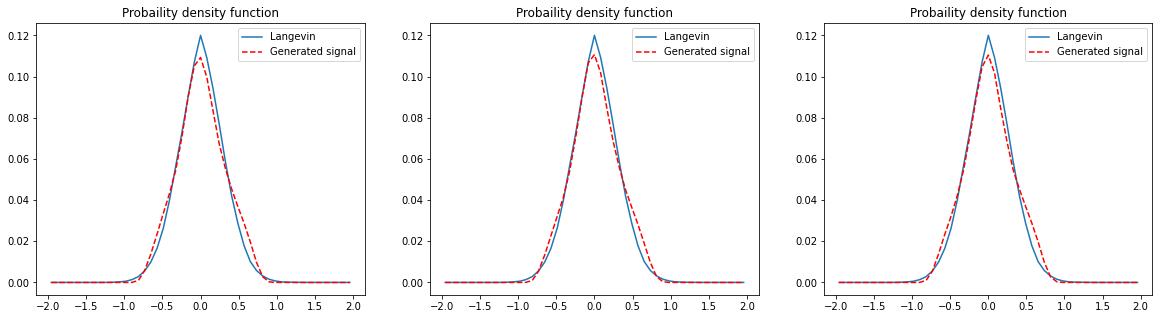

In [490]:
plt.figure(figsize=(20,5))
bins = np.linspace(-2,2,50)
hist_real,_ = np.histogram(langevin_1,bins = bins,density=True)
hist_real = hist_real/np.sum(hist_real)
plt.subplot(1,3,1)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_real,label='Langevin')
plt.plot((bins[1:] + bins[:-1]) / 2,hist_1,'r--',label='Generated signal')
plt.title('Probaility density function')
plt.legend()


plt.subplot(1,3,2)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_real,label='Langevin')
plt.plot((bins[1:] + bins[:-1]) / 2,hist_2,'r--',label='Generated signal')
plt.title('Probaility density function')
plt.legend()


plt.subplot(1,3,3)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_real,label='Langevin')
plt.plot((bins[1:] + bins[:-1]) / 2,hist_3,'r--',label='Generated signal')
plt.title('Probaility density function')
plt.legend()
plt.show()

#Extrapolating new time steps

In [0]:
#torch.save(netG.state_dict(), '/content/drive/My Drive/Colab Notebooks/lstm_gan.pt')

In [0]:
torch.cuda.empty_cache()
torch.save(netG.state_dict(),'/content/lstm_gan.pt')

In [493]:
device = torch.device("cpu")
netG = Generator(ngpu=0)
netG.load_state_dict(torch.load('/content/lstm_gan.pt'))

<All keys matched successfully>

In [0]:
num_examples_to_generate = 5000
#Generate Langevin with Tl = 0.05 t = 3*Tl
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate,nz,nPred*3, device=device)
label = torch.tensor(np.ones((num_examples_to_generate,1))*Tl[0],dtype=torch.float)
label = label.to(device)
predicted_langevin_1 = netG(noise,label,nPred*3)
predicted_langevin_1 = predicted_langevin_1.cpu().detach().numpy()
t1 = np.linspace(0,3,nPred*3)
#Generate Langevin with Tl = 0.05 t = 5*Tl
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate,nz,nPred*5, device=device)
label = torch.tensor(np.ones((num_examples_to_generate,1))*Tl[0],dtype=torch.float)
label = label.to(device)
predicted_langevin_2 = netG(noise,label,nPred*5)
predicted_langevin_2 = predicted_langevin_2.cpu().detach().numpy()
t2 = np.linspace(0,5,nPred*5)
#Generate Langevin with Tl = 0.05 t = 6*Tl
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate,nz,nPred*10, device=device)
label = torch.tensor(np.ones((num_examples_to_generate,1))*Tl[0],dtype=torch.float)
label = label.to(device)
predicted_langevin_3 = netG(noise,label,nPred*10)
predicted_langevin_3 = predicted_langevin_3.cpu().detach().numpy()
t3 = np.linspace(0,10,nPred*10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  del sys.path[0]


Text(0.5, 0, 't/Tl')

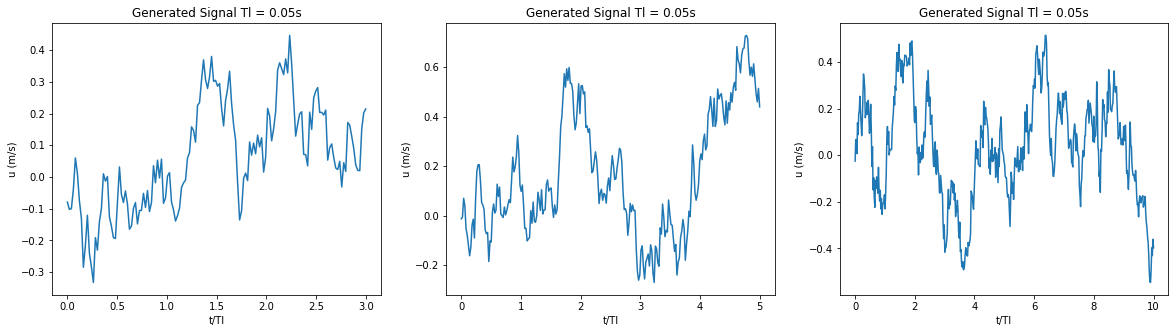

In [495]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(t1,predicted_langevin_1[np.random.random_integers(0,num_examples_to_generate-1),:,0])
plt.title("Generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
plt.subplot(1,3,2)
plt.plot(t2,predicted_langevin_2[np.random.random_integers(0,num_examples_to_generate-1),:,0])
plt.title("Generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
plt.subplot(1,3,3)
plt.plot(t3,predicted_langevin_3[np.random.random_integers(0,num_examples_to_generate-1),:,0])
plt.title("Generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")

Text(0.5, 0, 't/Tl')

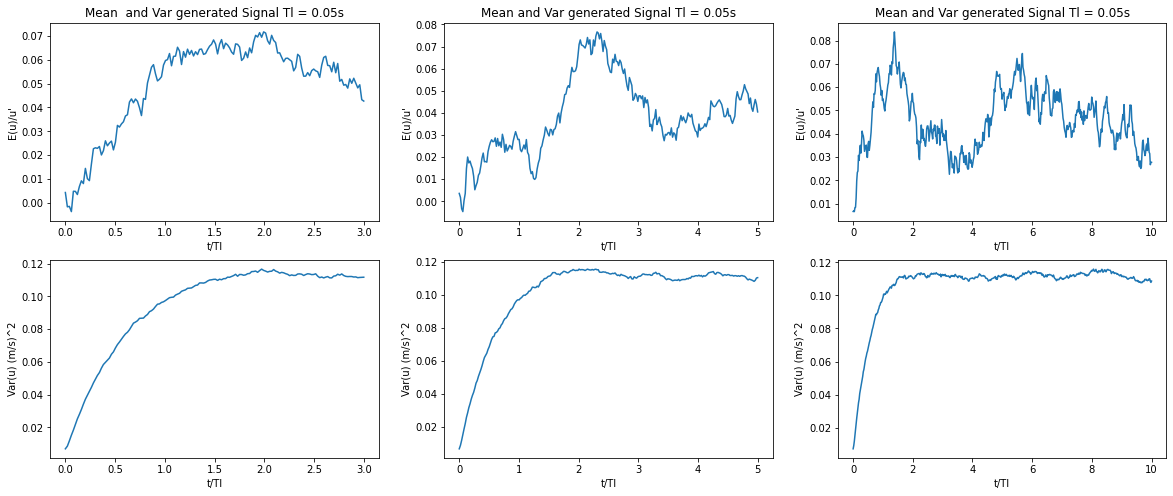

In [496]:
plt.figure(figsize=(20,8))
mean_gen = np.zeros(nPred*3)
var_gen = np.zeros(nPred*3)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_1[i,:,0]
    var_gen = var_gen + predicted_langevin_1[i,:,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen1 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)

plt.subplot(2,3,1)
plt.plot(t1,mean_gen)
plt.title("Mean  and Var generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,4)
plt.plot(t1,var_gen1)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

mean_gen = np.zeros(nPred*5)
var_gen = np.zeros(nPred*5)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_2[i,:,0]
    var_gen = var_gen + predicted_langevin_2[i,:,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen2 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,3,2)
plt.plot(t2,mean_gen)
plt.title("Mean and Var generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,5)
plt.plot(t2,var_gen2)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

mean_gen = np.zeros(nPred*10)
var_gen = np.zeros(nPred*10)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_3[i,:,0]
    var_gen = var_gen + predicted_langevin_3[i,:,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen3 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,3,3)
plt.plot(t3,mean_gen)
plt.title("Mean and Var generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,6)
plt.plot(t3,var_gen3)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

Text(0.5, 0, 'tau (s)')

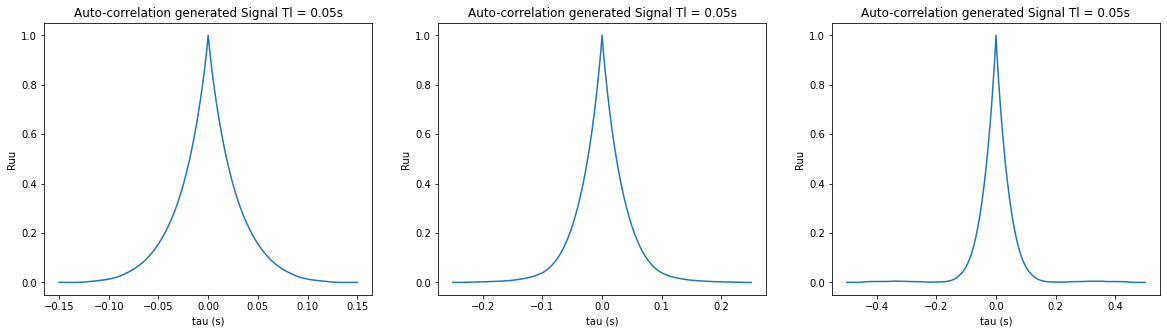

In [497]:
plt.figure(figsize=(20,5))
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_1[i,:,0])
Ruu_1 = Ruu/num_examples_to_generate
plt.subplot(1,3,1)
plt.plot(np.linspace(-Tl[0]*3,Tl[0]*3,nPred*2*3-1),Ruu_1)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_2[i,:,0])
Ruu_2 = Ruu/num_examples_to_generate
plt.subplot(1,3,2)
plt.plot(np.linspace(-Tl[0]*5,Tl[0]*5,nPred*2*5-1),Ruu_2)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_3[i,:,0])
Ruu_3 = Ruu/num_examples_to_generate
plt.subplot(1,3,3)
plt.plot(np.linspace(-Tl[0]*10,Tl[0]*10,nPred*2*10-1),Ruu_3)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning:

Text(0.5, 1.0, 'PDF generated Signal Tl = 1s')

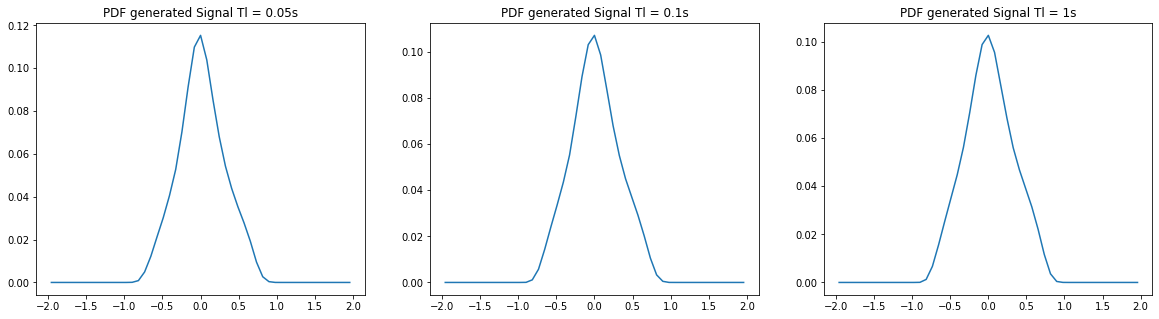

In [498]:
plt.figure(figsize=(20,5))
bins = np.linspace(-2,2,50)
hist_1,_ = np.histogram(predicted_langevin_1,bins = bins,normed=True)
hist_1 = hist_1/np.sum(hist_1)
plt.subplot(1,3,1)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_1)
plt.title("PDF generated Signal Tl = "+ str(Tl[0])+"s")
hist_2,_ = np.histogram(predicted_langevin_2,bins = bins,normed=True)
hist_2 = hist_2/np.sum(hist_2)
plt.subplot(1,3,2)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_2)
plt.title("PDF generated Signal Tl = "+ str(Tl[1])+"s")
hist_3,_ = np.histogram(predicted_langevin_3,bins = bins,normed=True)
hist_3 = hist_3/np.sum(hist_3)
plt.subplot(1,3,3)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_3)
plt.title("PDF generated Signal Tl = "+ str(Tl[2])+"s")